In [1]:
!nvidia-smi

Mon Oct 12 04:52:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    23W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
device = torch.device("cuda:0")
device

device(type='cuda', index=0)

Packages
=======================

In [3]:
import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import numpy as np

Import MNIST dataset and handle with it
==============================

In [5]:
from tensorflow.keras.datasets import mnist
(X_train_numpy, Y_train_numpy), (X_test_numpy, Y_test_numpy) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [6]:
label = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer", 
         5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

In [7]:
print(f"x_train's shape is {X_train_numpy.shape}\n x_test's shape is {X_test_numpy.shape}\n \
y_train's shape is {Y_train_numpy.shape}\n y_test's shape is {Y_test_numpy.shape}")

x_train's shape is (60000, 28, 28)
 x_test's shape is (10000, 28, 28)
 y_train's shape is (60000,)
 y_test's shape is (10000,)


In [8]:
label = set(Y_test_numpy)
label

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

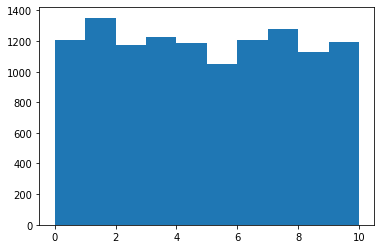

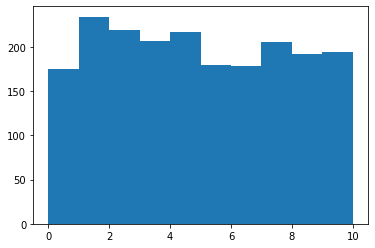

In [9]:
plt.hist(Y_train_numpy[0:12000], bins = [0,1,2,3,4,5,6,7,8,9,10]) 
plt.show()
plt.hist(Y_test_numpy[0:2000], bins = [0,1,2,3,4,5,6,7,8,9,10]) 
plt.show()

numpy -> pytorch and divide 255

In [10]:
X_train = torch.div(torch.from_numpy(X_train_numpy).type(torch.FloatTensor), 255)[0:12000, 0:28, 0:28].cuda()
X_test = torch.div(torch.from_numpy(X_test_numpy).type(torch.FloatTensor), 255)[0:2000].cuda()
Y_train = torch.from_numpy(Y_train_numpy).type(torch.long)[0:12000].cuda()
Y_test = torch.from_numpy(Y_test_numpy).type(torch.long)[0:2000].cuda()

print(f"{X_train.size()} : {X_test.size()}\n {Y_train.size()} : {Y_test.size()}")

torch.Size([12000, 28, 28]) : torch.Size([2000, 28, 28])
 torch.Size([12000]) : torch.Size([2000])


MLP
==================

*   Input is input layer
*   the first Linear Layer is the first hidden layer
*   the last Linear Layer is the output layer

MLP1
---------------------

In [31]:
class MLP1(nn.Module):
    def __init__(self):
        super(MLP1, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('do1', nn.Dropout(0.5)),
            ('fc1', nn.Linear(28 * 28, 100)),  # hidden layer1
            ('bn1', nn.BatchNorm1d(100)),
            ('relu1', nn.ReLU()),
            ('do2', nn.Dropout(0.5)),
            ('fc2', nn.Linear(100, 200)),  # hidden layer2
            ('bn2', nn.BatchNorm1d(200)),
            ('relu2', nn.ReLU()),
            ('do3', nn.Dropout(0.5)),
            ('fc3', nn.Linear(200, 10)), # output layer
            ('softmax1', nn.Softmax(dim=1))
        ]))
        # self.fc1   = nn.Linear(28 * 28, 1500)
        # self.fc2   = nn.Linear(1500, 10)
        self.ce = nn.CrossEntropyLoss()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.model(x)
        return x

    # x.size(0) = y.size(0)
    def loss(self, x, y):
        loss = self.ce(x, y)
        return loss


MLP2
-------------------

In [12]:
class MLP2(nn.Module):
    def __init__(self):
        super(MLP2, self).__init__()
        self.model = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(28 * 28, 50)),  # hidden layer1
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(50, 30)),  # hidden layer2
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(30, 10)), # output layer
            ('softmax1', nn.Softmax(dim=1))
        ]))
        self.ce = nn.CrossEntropyLoss()
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = self.model(x)
        return x

    # x.size(0) = y.size(0)
    def loss(self, x, y):
        loss = self.ce(x, y)
        return loss


how to modify the layer (don't run)
----------------------------
move mlp1 to gpu

In [13]:
mlp1 = MLP1().cuda()
print(mlp1)

MLP1(
  (model): Sequential(
    (fc1): Linear(in_features=784, out_features=100, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=100, out_features=200, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=200, out_features=10, bias=True)
    (softmax1): Softmax(dim=1)
  )
  (ce): CrossEntropyLoss()
)


forward and loss

In [14]:
out = mlp1(X_train)
loss = mlp1.loss(out, Y_train)

move mlp1 back to cpu

In [12]:
mlp1.cpu()

MLP1(
  (model): Sequential(
    (fc1): Linear(in_features=784, out_features=100, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=100, out_features=200, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=200, out_features=10, bias=True)
    (softmax1): Softmax(dim=1)
  )
  (ce): CrossEntropyLoss()
)

modify layers

In [13]:
mlp1.model.fc1 = nn.Linear(28 * 28, 200)
mlp1.model.fc2 = nn.Linear(200, 200 + 100)
mlp1.model.fc3 = nn.Linear(200 + 100, 10)

move it back to gpu

In [14]:
mlp1.cuda()

MLP1(
  (model): Sequential(
    (fc1): Linear(in_features=784, out_features=200, bias=True)
    (relu1): ReLU()
    (fc2): Linear(in_features=200, out_features=300, bias=True)
    (relu2): ReLU()
    (fc3): Linear(in_features=300, out_features=10, bias=True)
    (softmax1): Softmax(dim=1)
  )
  (ce): CrossEntropyLoss()
)

do forward and loss

In [15]:
out = mlp1(X_train)
loss = mlp1.loss(out, Y_train)

AVG
======================
calculate average loss and correct

In [15]:
# class Avg_para():
#     def __init__(self, m):
#         self.m = m
#         self.para_list = []
#         self.times = 0
    
#     def init_para(self):
#         for para in self.m.parameters():
#             self.para_list.append(torch.zeros_like(para.data))

#     def update_para(self):
#         self.times += 1
#         for (para_sum, para) in zip(self.para_list, self.m.parameters()):
#             para_sum.add_(para.data)

#     def reload_para(self):
#         for (para_sum, para) in zip(self.para_list, self.m.parameters()):
#             para.data = para_sum.div_(self.times)

In [16]:
# x, y,
def avg(m, x, y, x_test, y_test, epochs = 2000, times=15, isgpu=True):
    avg_loss = 0
    avg_corr = 0
    avg_test_corr = 0
    epochs = epochs
    
    # try multiple times to get average
    for time in range(times):
        # reset parameters
        for layer in m.model:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()
        optimizer = optim.SGD(m.parameters(), lr=0.1)
        for epoch in range(epochs):
            optimizer.zero_grad()
            out = m(x)
            loss = m.loss(out, y)
            loss.backward()
            optimizer.step()  # updates parameters

        # accumulate loss, corr, test_corr
        # accuracy
        out = m(x)
        pred = out.data.max(1, keepdim=False)[1]
        if isgpu: 
            correct = pred.eq(y.data.view_as(pred)).cpu().detach().sum()
        else: 
            correct = pred.eq(y.data.view_as(pred)).detach().sum()
        correct_rate = correct.detach().item() / x.size()[0]
        avg_corr += correct_rate
        # loss
        avg_loss += loss.item()
        # accuracy test
        out_test = m(x_test)
        pred_test = out_test.data.max(1, keepdim=False)[1]
        if isgpu:
            correct_test = pred_test.eq(y_test.data.view_as(pred_test)).cpu().detach().sum()
        else:
            correct_test = pred_test.eq(y_test.data.view_as(pred_test)).detach().sum()
        avg_test_corr += correct_test.detach().item() / x_test.size()[0]

    return avg_loss / times, avg_corr / times, avg_test_corr / times

test

In [17]:
mlp1 = MLP1().cuda()

In [19]:
loss, corr, corr_test = avg(mlp1, X_train, Y_train, X_test, Y_test)

In [21]:
corr, corr_test

(0.8658777777777779, 0.8264999999999999)

Execute
===============


explore batch normalization and dropout on cpu
---------------------

no batch normalization

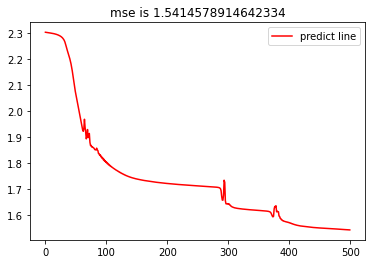

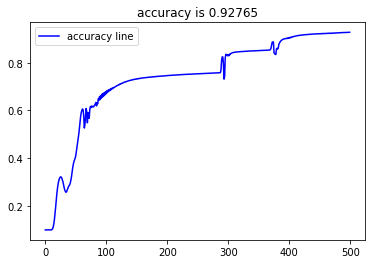

In [22]:
mlp2 = MLP2()
epoch = 500
optimizer = optim.SGD(mlp2.parameters(), lr=1)
epoch_list = []
loss_list = []
accu_list = []

while(epoch > 0):
    optimizer.zero_grad()
    out = mlp2(torch.div(torch.from_numpy(X_train_numpy).type(torch.FloatTensor), 255))
    loss = mlp2.loss(out, torch.from_numpy(Y_train_numpy).type(torch.long))
    loss.backward()
    optimizer.step()  # updates parameters

    pred = out.data.max(1, keepdim=False)[1]
    correct = pred.eq(torch.from_numpy(Y_train_numpy).type(torch.long).data.view_as(pred)).detach().sum()
    correct_rate = correct.detach().item() / X_train_numpy.shape[0]

    epoch_list.append((500-epoch))
    loss_list.append(loss.item())
    accu_list.append(correct_rate)

    epoch -= 1

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse is {loss}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=accu_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy is {correct_rate}")
plt.show()

In [23]:
out = mlp2(torch.div(torch.from_numpy(X_test_numpy).type(torch.FloatTensor), 255))
pred = out.data.max(1, keepdim=False)[1]
correct = pred.eq(torch.from_numpy(Y_test_numpy).type(torch.long).data.view_as(pred)).detach().sum()
correct_rate = correct.detach().item() / X_test_numpy.shape[0]
correct_rate

0.9255

add batch normalization

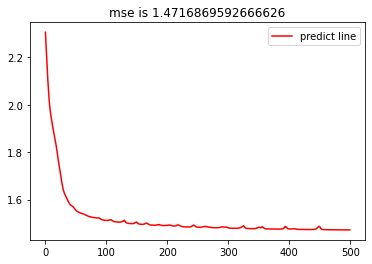

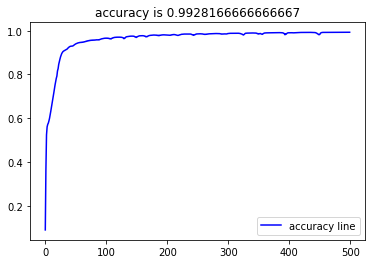

In [24]:
mlp2 = MLP2()
mlp2.model = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(28 * 28, 50)),  # hidden layer1
            ('bn1', nn.BatchNorm1d(50)),
            ('relu1', nn.ReLU()),
            ('fc2', nn.Linear(50, 30)),  # hidden layer2
            ('bn2', nn.BatchNorm1d(30)),
            ('relu2', nn.ReLU()),
            ('fc3', nn.Linear(30, 10)), # output layer
            ('softmax1', nn.Softmax(dim=1))
        ]))
epoch = 500
optimizer = optim.SGD(mlp2.parameters(), lr=1)
epoch_list = []
loss_list = []
accu_list = []

while(epoch > 0):
    optimizer.zero_grad()
    out = mlp2(torch.div(torch.from_numpy(X_train_numpy).type(torch.FloatTensor), 255))
    loss = mlp2.loss(out, torch.from_numpy(Y_train_numpy).type(torch.long))
    loss.backward()
    optimizer.step()  # updates parameters

    pred = out.data.max(1, keepdim=False)[1]
    correct = pred.eq(torch.from_numpy(Y_train_numpy).type(torch.long).data.view_as(pred)).detach().sum()
    correct_rate = correct.detach().item() / X_train_numpy.shape[0]

    epoch_list.append((500-epoch))
    loss_list.append(loss.item())
    accu_list.append(correct_rate)

    epoch -= 1

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse is {loss}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=accu_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy is {correct_rate}")
plt.show()

In [25]:
out = mlp2(torch.div(torch.from_numpy(X_test_numpy).type(torch.FloatTensor), 255))
pred = out.data.max(1, keepdim=False)[1]
correct = pred.eq(torch.from_numpy(Y_test_numpy).type(torch.long).data.view_as(pred)).detach().sum()
correct_rate = correct.detach().item() / X_test_numpy.shape[0]
correct_rate

0.9721

add dropout

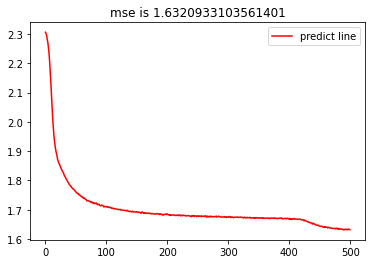

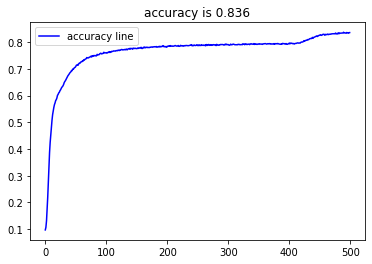

In [28]:
mlp2 = MLP2()
mlp2.model = nn.Sequential(OrderedDict([
            ('do1', nn.Dropout(0.5)),
            ('fc1', nn.Linear(28 * 28, 50)),  # hidden layer1
            ('bn1', nn.BatchNorm1d(50)),
            ('relu1', nn.ReLU()),
            ('do2', nn.Dropout(0.5)),
            ('fc2', nn.Linear(50, 30)),  # hidden layer2
            ('bn2', nn.BatchNorm1d(30)),
            ('relu2', nn.ReLU()),
            ('do3', nn.Dropout(0.5)),
            ('fc3', nn.Linear(30, 10)), # output layer
            ('softmax1', nn.Softmax(dim=1))
        ]))
epoch = 500
optimizer = optim.SGD(mlp2.parameters(), lr=1, momentum=0.9)
epoch_list = []
loss_list = []
accu_list = []

while(epoch > 0):
    optimizer.zero_grad()
    out = mlp2(torch.div(torch.from_numpy(X_train_numpy).type(torch.FloatTensor), 255))
    loss = mlp2.loss(out, torch.from_numpy(Y_train_numpy).type(torch.long))
    loss.backward()
    optimizer.step()  # updates parameters

    pred = out.data.max(1, keepdim=False)[1]
    correct = pred.eq(torch.from_numpy(Y_train_numpy).type(torch.long).data.view_as(pred)).detach().sum()
    correct_rate = correct.detach().item() / X_train_numpy.shape[0]

    epoch_list.append((500-epoch))
    loss_list.append(loss.item())
    accu_list.append(correct_rate)

    epoch -= 1

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse is {loss}")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=epoch_list, y=accu_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy is {correct_rate}")
plt.show()

In [30]:
out = mlp2(torch.div(torch.from_numpy(X_test_numpy).type(torch.FloatTensor), 255))
pred = out.data.max(1, keepdim=False)[1]
correct = pred.eq(torch.from_numpy(Y_test_numpy).type(torch.long).data.view_as(pred)).detach().sum()
correct_rate = correct.detach().item() / X_test_numpy.shape[0]
correct_rate

0.8348

width of layer1
---------------------------------------
check from 100 nodes to 1700 nodes

In [ ]:
from tqdm.notebook import tnrange, tqdm_notebook

width_list = []
loss_list = []
correct_list = []
correct_test_list = []
mlp1 = MLP1() # on cpu


for width in tnrange(100, 1700, 100, desc='width'):
    
    # change the width of the layer
    mlp1.cpu() # move to cpu to prepare for the modification of layers
    mlp1.model.fc1 = nn.Linear(28 * 28, width)
    mlp1.model.bn1 = nn.BatchNorm1d(width)
    mlp1.model.fc2 = nn.Linear(width, width + 100)
    mlp1.model.bn2 = nn.BatchNorm1d(width + 100)
    mlp1.model.fc3 = nn.Linear(width + 100, 10)
    mlp1.cuda() # move back to gpu
    
    loss, correct_rate, correct_test = avg(mlp1, X_train, Y_train, X_test, Y_test, epochs = 2000, times=15)
            
    print(f"in {width}: loss is {loss}, accu is {correct_rate}")
    width_list.append(width)
    loss_list.append(loss)
    correct_list.append(correct_rate)
    correct_test_list.append(correct_test)

fig, ax = plt.subplots()
sns.lineplot(x=width_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=width_list, y=correct_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=width_list, y=correct_test_list, color='blue', label='accuracy test line', ax=ax)
plt.title(f"accuracy")
plt.show()

width of layer2
-----------------------
from 10 to 100

In [ ]:
from tqdm.notebook import tnrange, tqdm_notebook

width_list = []
loss_list = []
correct_list = []
mlp1 = MLP1() # on cpu


for width in tnrange(10, 100, 5, desc='width'):
    
    # change the width of the layer
    mlp1.cpu() # move to cpu to prepare for the modification of layers
    mlp1.model.fc1 = nn.Linear(28 * 28, width)
    mlp1.model.fc2 = nn.Linear(width, width + 100)
    mlp1.model.fc3 = nn.Linear(width + 100, 10)
    mlp1.cuda() # move back to gpu
    
    loss, correct_rate = avg(mlp1, X_train, Y_train, epochs = 2000, times=15)
            
    print(f"in {width}: loss is {loss}, accu is {correct_rate}")
    width_list.append(width)
    loss_list.append(loss)
    correct_list.append(correct_rate)

fig, ax = plt.subplots()
sns.lineplot(x=width_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=width_list, y=correct_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy")
plt.show()

width of layer3
---------------------
use MLP2 a simple architecture

In [ ]:
from tqdm.notebook import tnrange, tqdm_notebook

width_list = []
loss_list = []
correct_list = []
correct_list_test = []
mlp2 = MLP2() # on cpu


for width in tnrange(50, 300, 10, desc='width'):

    # change the width of the layer
    mlp2.cpu() # move to cpu to prepare for the modification of layers
    mlp2.model.fc1 = nn.Linear(28 * 28, width)
    mlp2.model.fc2 = nn.Linear(width, width + 10)
    mlp2.model.fc3 = nn.Linear(width + 10, 10)
    mlp2.cuda() # move back to gpu
    
    loss, correct_rate, correct_test_rate = avg(mlp2, X_train, Y_train, X_test, Y_test, epochs = 2000, times=10)
            
    print(f"in {width}: loss is {loss}, accu is {correct_rate}, test rate is {correct_test_rate}")
    width_list.append(width)
    loss_list.append(loss)
    correct_list.append(correct_rate)
    correct_list_test.append(correct_test_rate)


fig, ax = plt.subplots()
sns.lineplot(x=width_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=width_list, y=correct_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=width_list, y=correct_list_test, color='blue', label='accuracy test line', ax=ax)
plt.title(f"accuracy")
plt.show()

depth of layer1
----------------------------

In [ ]:
from tqdm.notebook import tnrange, tqdm_notebook

depth_list = []
loss_list = []
correct_list = []
correct_list_test = []
mlp1 = MLP1() # on cpu

former_list = [
    ('fc1', nn.Linear(28 * 28, 20)),  # hidden layer1
    ('relu1', nn.ReLU()),
    ('fc2', nn.Linear(20, 20)),  # hidden layer2
    ('relu2', nn.ReLU())
]


latter_list = [
    ('fc3', nn.Linear(20, 10)), # output layer
    ('softmax1', nn.Softmax(dim=1))
]

mid_list = []

for layer in tnrange(0, 4, 1, desc='depth'):
    mid_list.append(('add_fc' + str(layer), nn.Linear(20, 20)))
    mid_list.append(('add_relu' + str(layer), nn.ReLU()))

    l = nn.Sequential(OrderedDict(former_list + mid_list + latter_list))

    # change the width of the layer
    mlp1.cpu() # move to cpu to prepare for the modification of layers
    mlp1.model = l
    mlp1.cuda() # move back to gpu
    print(mlp1)

    loss, correct_rate, correct_test_rate = avg(mlp1, X_train, Y_train, X_test, Y_test, epochs = 3000, times=15)
            
    print(f"in {layer}: loss is {loss}, accu is {correct_rate}, test rate is {correct_test_rate}")
    depth_list.append(layer)
    loss_list.append(loss)
    correct_list.append(correct_rate)
    correct_list_test.append(correct_test_rate)

fig, ax = plt.subplots()
sns.lineplot(x=depth_list, y=loss_list, color='red', label='predict line', ax=ax)
plt.title(f"mse")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=depth_list, y=correct_list, color='blue', label='accuracy line', ax=ax)
plt.title(f"accuracy")
plt.show()

fig, ax = plt.subplots()
sns.lineplot(x=depth_list, y=correct_list_test, color='blue', label='accuracy test line', ax=ax)
plt.title(f"accuracy")
plt.show()